## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продавать больше туров. Разработано два варианта посадочной страницы официального сайта компании и проведено A/B-тестирование. Собранные в результате проведения эксперимента данные необходимо проанализировать.

Требуется решить бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Предоставленные данные:

Собранные данные: ab_data_tourist.csv

Информация по вариантам туров и их стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Загрузим данные и изучим таблицу:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Посмотрим на структуру данных. С помощью метода info() выведем информацию о типах данных и количестве непустых значений. 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Столбец date имеет тип данных object, т.е. строковый.

## **Задание 7.2.**

Приведем столбец date к типу данных datetime. Убедимся в равной длительности проведения тестирования для каждой из группы. Для этого сгруппирем данные по признаку группы и определим первую и последнюю дату наблюдения для каждой из групп. 

In [4]:
# помимо приведения к типу datetime выделим дату в чистом виде
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.date
# сгруппируем данные по группам А и В, и найдем минимум и максимум
date_min = data.groupby('group', as_index=False).agg({'date': 'min'}).rename(columns={'date': 'date_min'})
date_max = data.groupby('group', as_index=False).agg({'date': 'max'}).rename(columns={'date': 'date_max'})
# объединим эти выборки и выведем 
print(pd.merge(date_min, date_max, on='group'))
print()
# проверим, что начало и конец тестирования для групп А и В совпадают
if (date_min.date_min[0] == date_min.date_min[1]) & (date_max.date_max[0] == date_max.date_max[1]):
    print('Длительности проведения тестирования каждой группы равны')
else:
    print('Длительности проведения тестирования каждой группы НЕ равны')
print()
print(f'Тест проводился в промежуток с {date_min.date_min.min()} по {date_max.date_max.max()}')

  group    date_min    date_max
0     A  2021-01-02  2021-01-24
1     B  2021-01-02  2021-01-24

Длительности проведения тестирования каждой группы равны

Тест проводился в промежуток с 2021-01-02 по 2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна общая сумма всех покупок в группах А и B? Ответ приведем в миллионах рублей. 

In [5]:
# сгруппируем по группам А и В и посчитаем требуемое для каждой группы
vizits = data.groupby('group').agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'})
vizits = vizits.rename(columns={'user_id': 'visit_count', 'purchase': 'purchase_count', 'price': 'purchase_sum'})
vizits['purchase_sum'] = vizits['purchase_sum'].apply(lambda x: x/10**6)
# вывод в соответствии с вопросами
vizits

,visit_count,purchase_count,purchase_sum
group,,,
A,147202,17723,1436.26
B,147276,17514,1554.10


## **Задание 7.4.**

Проверим, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то определим их количество, если нет - укажем 0.

In [6]:
# сформируем два списка пользователей в группах А и В  
# по  уникальному user_id и определим их пересечение, 
# т.е. найдем user_id, которые входят в обе группы
user_a = set(data[data['group'] == 'A']['user_id'].to_list())
user_b = set(data[data['group'] == 'B']['user_id'].to_list())
user_intersection = user_a.intersection(user_b)
if user_intersection == 0:
    print('Нет пользователей, которые попали в обе тестовые группы. Их количество = 0')
else:
    print('Есть пользователи, которые попали в обе тестовые группы. Их количество =', len(user_intersection))

Есть пользователи, которые попали в обе тестовые группы. Их количество = 1895


### **Исключим пользователей, оказавшихся в обеих группах**

Так как нет возможности определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее будем работать только с очищенными от пересечений данными.

In [7]:
# исключим записи с user_id, которые входят в пересечение,
# ulе user_intersection - множество пересечений пользователей групп А и B.
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

updated_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290688 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   290688 non-null  int64 
 1   date      290688 non-null  object
 2   group     290688 non-null  object
 3   purchase  290688 non-null  int64 
 4   price     290688 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 13.3+ MB


## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования подготовим таблицу следующего вида:

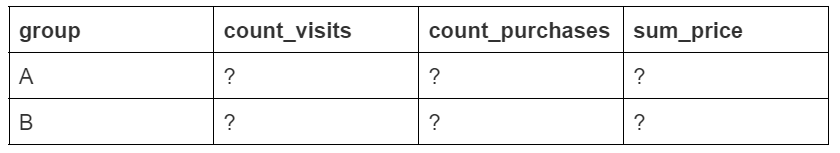
 
 
Для того, чтобы получить такую таблицу, сгруппируем данные по признаку группы. В каждой группе рассчитаем следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуем столбцы на **count_visits, count_purchases и sum_price**.

Определим чему равно количество посещений сайта в группах А и B?


In [8]:
data_group = updated_data.groupby('group').agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'})
data_group = data_group.rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'}).reset_index()

print(f'Количество посещений сайта в группах А и В составляет: {data_group.count_visits[0]} и {data_group.count_visits[1]}, соответственно.')

# вывод всей таблицы
data_group

Количество посещений сайта в группах А и В составляет: 145307 и 145381, соответственно.


,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Промежуточные выводы:

Количество посещений обоих вариантов посадочной странице сопоставимо, разница составляет всего 0.05 %. Можно говорить о том, что выборки сбалансированы.

## **Задание 7.6.**

Добавим в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Определим чему равна конверсия в группах (ответ в процентах и округлен до сотых)
* Определим чему равен средний чек в группах (ответ в рублях и округлен до целых)

In [9]:
data_group['conversion'] = data_group['count_purchases']/data_group['count_visits']*100
data_group['mean_check'] = round(data_group['sum_price']/data_group['count_purchases'])

print(f'Конверсия покупки в группе А: {round(data_group.conversion[0], 2)}')
print(f'Конверсия покупки в группе В: {round(data_group.conversion[1], 2)}')
print()
print(f'Средний чек в группе А: {data_group.mean_check[0]}')
print(f'Средний чек в группе В: {data_group.mean_check[1]}')

# вывод всей таблицы
data_group

Конверсия покупки в группе А: 12.03
Конверсия покупки в группе В: 11.89

Средний чек в группе А: 81076.0
Средний чек в группе В: 88665.0


,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.034520,81076.0
1,B,145381,17290,1533010000,11.892888,88665.0


Промежуточные выводы:

По показателю "конверсия покупки" вариант А эффективнее (на 1.2 %). По показателю "средний чек" вариант В эффективнее (на 8.5 %). 

## **Задание 7.7.**

Теперь сравним варианты по покупательской способности туров. Для этого построим сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [10]:
data_pivot = pd.pivot_table(
    data=updated_data[updated_data['purchase'] == 1],
    values='purchase',
    index='group',
    columns='price',
    aggfunc='sum'
)

# вывод всей таблицы
data_pivot

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируем полученную сводную таблицу с помощью тепловой карты с аннотацией. 

Определим чему равно количество проданных туров за 60000 рублей в группах А и В.

<Axes: xlabel='price', ylabel='group'>

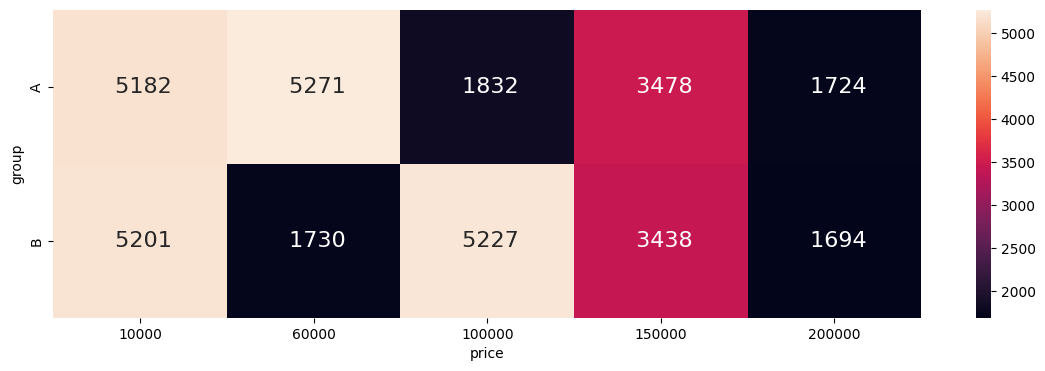

In [11]:
plt.figure(figsize = (14,4))

sns.heatmap(data_pivot, annot=True, fmt=" d", annot_kws={'size': 16})

Количество проданных туров за 60000 рублей в группах А и В составляет: 5271 и 1730, соответственно.

Выводы по покупательной способности участников групп А и В:

Покупательская способность участников группы А выше, чем участников группы B по туру "60000 рублей". Покупательская способность участников группы В выше, чем участников группы А по туру "100000 рублей". По остальным турам покупательные способности участников рупп А и В примерно равны (разница не более 1.7 %).

## **Задание 7.8.**

Построим таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируем данные по дате и группе тестирования. В каждой группе вычислим количество посещений страницы, количество покупок и сумму покупок. 

Добавим в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Определим чему равна конверсия 3 января 2021 года (ответ в процентах и округлен до сотых)

* Определим чему равен средний чек 3 января 2021 года (ответ в рублях и округлен до целого)

In [12]:
# используем таблицу, очищенную от пересечений посещений в группах
daily_data = updated_data.groupby(['date', 'group']).agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}).reset_index()
daily_data = daily_data.rename(columns={'user_id': 'daily_visits', 'purchase': 'daily_purchases', 'price': 'daily_sum'})
# создаем новые признаки ежедневных конверсии и среднего чека
daily_data['daily_conversion'] = daily_data['daily_purchases']/daily_data['daily_visits']*100
daily_data['daily_mean_check'] = round(daily_data['daily_sum']/daily_data['daily_purchases'])
# приведем дату к правильному формату datetime
daily_data['date'] = pd.to_datetime(daily_data['date'])
# маски для групп А и В
mask_a = (daily_data['date'] == '2021-01-03') & (daily_data['group'] == 'A')
mask_b = (daily_data['date'] == '2021-01-03') & (daily_data['group'] == 'B')
# ответы на поставленные вопросы
print('Конверсия 3 января 2021 года для группы А = ', round(daily_data[mask_a]['daily_conversion'].values[0], 2))
print('Конверсия 3 января 2021 года для группы В = ', round(daily_data[mask_b]['daily_conversion'].values[0], 2))
print()
print('Средний чек 3 января 2021 года для группы А = ', int(daily_data[mask_a]['daily_mean_check'].values[0]))
print('Средний чек 3 января 2021 года для группы В = ', int(daily_data[mask_b]['daily_mean_check'].values[0]))
# вывод всей таблицы
daily_data.head()


Конверсия 3 января 2021 года для группы А =  11.34
Конверсия 3 января 2021 года для группы В =  11.39

Средний чек 3 января 2021 года для группы А =  82888
Средний чек 3 января 2021 года для группы В =  87480


,date,group,daily_visits,daily_purchases,daily_sum,daily_conversion,daily_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.0
1,2021-01-02,B,2861,345,29660000,12.058721,85971.0
2,2021-01-03,A,6596,748,62000000,11.340206,82888.0
3,2021-01-03,B,6619,754,65960000,11.391449,87480.0
4,2021-01-04,A,6566,799,64250000,12.168748,80413.0


## **Задание 7.9.** 

Добавим в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Вычислим кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Определим какая **кумулятивная** конверсия была в группе B на 20 января 2021 года (ответ в процентах, округлен до сотых)
* Определи какой **кумулятивный** средний чек был в группе А на 12 января 2021 года (ответ в рублях, округлен до целых)

In [13]:
# вычисляем кумулятивные признаки с учетом деления на группы А и В
daily_data['cum_daily_visits'] = daily_data.groupby(['group'])['daily_visits'].cumsum()
daily_data['cum_daily_purchases'] = daily_data.groupby(['group'])['daily_purchases'].cumsum()
daily_data['cum_daily_sum'] = daily_data.groupby(['group'])['daily_sum'].cumsum()

daily_data['cum_conversion'] = daily_data['cum_daily_purchases']/daily_data['cum_daily_visits']*100
daily_data['cum_mean_check'] = round(daily_data['cum_daily_sum']/daily_data['cum_daily_purchases'])

mask_b = (daily_data['date'] == '2021-01-20') & (daily_data['group'] == 'B')
print('Кумулятивная конверсия в группе B на 20 января 2021 года: ', round(daily_data[mask_b]['cum_conversion'].values[0], 2))
mask_a = (daily_data['date'] == '2021-01-12') & (daily_data['group'] == 'A')
print('Кумулятивный средний чек в группе А на 12 января 2021 года: ', int(daily_data[mask_a]['cum_mean_check'].values[0]))
# вывод всей таблицы
daily_data.head()

Кумулятивная конверсия в группе B на 20 января 2021 года:  11.9
Кумулятивный средний чек в группе А на 12 января 2021 года:  81492


,date,group,daily_visits,daily_purchases,daily_sum,daily_conversion,daily_mean_check,cum_daily_visits,cum_daily_purchases,cum_daily_sum,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.0,2854,359,29410000,12.578837,81922.0
1,2021-01-02,B,2861,345,29660000,12.058721,85971.0,2861,345,29660000,12.058721,85971.0
2,2021-01-03,A,6596,748,62000000,11.340206,82888.0,9450,1107,91410000,11.714286,82575.0
3,2021-01-03,B,6619,754,65960000,11.391449,87480.0,9480,1099,95620000,11.592827,87006.0
4,2021-01-04,A,6566,799,64250000,12.168748,80413.0,16016,1906,155660000,11.900599,81668.0


Построим кумулятивные графики конверсии и среднего чека для каждой группы по дням. Сделаем выводы о том, можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени. Выясним как соотносятся кумулятивные показатели каждой группы.

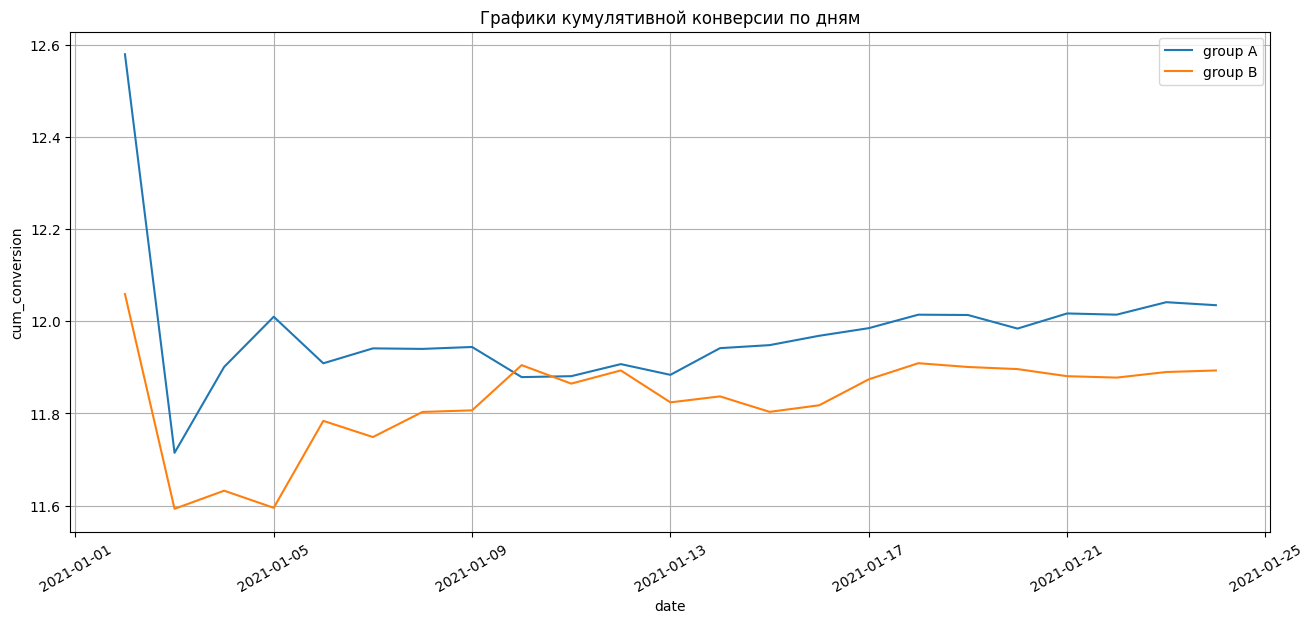

In [14]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_conversion', data=daily_data[daily_data['group'] == 'A'], ax=ax, label='group A')
sns.lineplot(x='date', y='cum_conversion', data=daily_data[daily_data['group'] == 'B'], ax=ax, label='group B')
ax.set_title('Графики кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation = 30)
ax.grid(True);

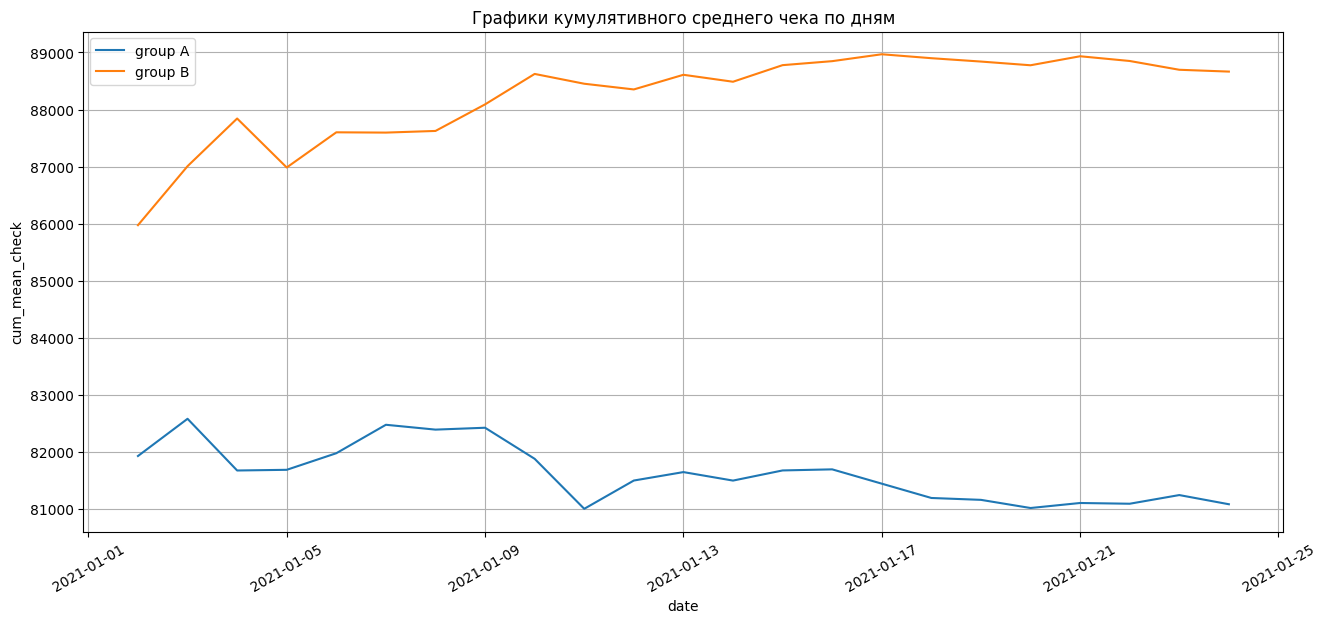

In [15]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_mean_check', data=daily_data[daily_data['group'] == 'A'], ax=ax, label='group A')
sns.lineplot(x='date', y='cum_mean_check', data=daily_data[daily_data['group'] == 'B'], ax=ax, label='group B')
ax.set_title('Графики кумулятивного среднего чека по дням')
ax.xaxis.set_tick_params(rotation = 30)
ax.grid(True);

В отношении кумулятивной конверсии можно считать, что она стабилизировалась начиная с 15 января 2021 года. При этом конверсия группы А стабильно лучше конверсии группы В (однако разница всего 1-1.5 %).

В отношении кумулятивного среднего чека  - стабилизация наблюдается практически с начала наблюдения. С 18 января 2021 года разница между группами В и А стабилизировалась. Средний чек группы В стабильно больше среднего чека группы А (примерно 8-9 %).

## **Задание 7.10.**

Проверим статистическую значимость разницы между метриками в группах. Начнем с конверсии.

Выберем тест для проверки гипотезы о равенстве конверсий в группах.

Проведем тестирование при следующих нулевой и альтернативной гипотезах:
* $H0$: Конверсии в группах А и B равны.
* $H1$: Конверсия в группе А больше чем конверсия в группе B.

Вычислим p-value нашего теста для конверсий в группах А и B. Сравним полученные значения p-value с уровнем значимости 0.05. 

Для проверки гипотезы о равенстве конверсий в группах будет применен Z-тест для пропорций.

In [16]:
# вывод используемой таблицы
data_group

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.034520,81076.0
1,B,145381,17290,1533010000,11.892888,88665.0


In [17]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны.'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B.'
# уровень значимости
alpha = 0.05

# вычисляем значение p-value для z-теста для пропорций
stat, p_value = proportions_ztest(
    count=data_group['count_purchases'], # число покупок в группах
    nobs=data_group['count_visits'], # общее число посещений в группах
    alternative='larger' # согласно альтернативной гипотезе 
)

# выводим результат на экран
print('p-value: %.2f' % p_value)

# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print('Отвергаем нулевую гипотезу H0.')
    print(f'Принимаем альтернативную гипотезу H1: {H1}')
else:
    print(f'Принимаем нулевую гипотезу H0: {H0}')

p-value: 0.12
Принимаем нулевую гипотезу H0: Конверсии в группах А и B равны.


Выводы по результатам проведенного теста:

Так как z-тест для пропорций показал, что истинные значения конверсий в группах равны (с установленным уровнем значимости 0.05), то полученная разница в метриках конверсий в группах А и В статистически не значима (отсутствует статистическая разница). Т.е. конверсии в группах А и В равны.

## **Задание 7.11.**
Убедимся в своих рассуждениях, построив 95 % доверительный интервал для конверсий и разницы между ними. Используем $z_{крит}$ в своих расчетах.

Укажем нижнюю и верхнюю границы доверительных интервалов. Границы приведем в процентах и округлим до 2 знака после запятой. 

In [18]:
# используем оригинальную таблицу, но 
# исключим записи, которые входят 
# и в группу А и в группу B
updated_data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Доверительные интервалы для конверсий групп А и В:

In [19]:
def proportions_conf_interval(n, x_p, gamma=0.95):
    """функция для вычисления доверительного интервала пропорции

    Args:
        n (int): размер выборки
        x_p (float): выборочная пропорция
        gamma (float, optional): уровень надежности

    Returns:
        кортеж из двух целых чисел - нижняя и верхняя 
        границы доверительного интервалапропорции, 
        округленные до целого
    """    
    
    
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 # погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)


# строим доверительный интервал для конверсии группы А
conf_interval_a = proportions_conf_interval(
    n=updated_data[updated_data['group'] == 'A']['user_id'].count(), 
    x_p=updated_data[updated_data['group'] == 'A']['purchase'].mean() 
)
# строим доверительный интервал для конверсии группы В
conf_interval_b = proportions_conf_interval(
    n=updated_data[updated_data['group'] == 'B']['user_id'].count(), 
    x_p=updated_data[updated_data['group'] == 'B']['purchase'].mean() 
)

print(f'Доверительный интервал для конверсии группы А: {conf_interval_a}')
print(f'Доверительный интервал для конверсии группы B: {conf_interval_b}')

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


Доверительный интервал разницы между конверсиями групп А и В:

In [20]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    """функция для вычисления доверительного интервала разницы пропорций

    Args:
        n (list of int): список из размеров 2-х выборок 
        x_p (float): список их 2-х выборочных пропорций
        gamma (float, optional): уровень надежности

    Returns:
        кортеж из двух целых чисел - нижняя и верхняя 
        границы доверительного интервала разницы пропорций, 
        округленные до целого
    """    
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)


# задаем размеры выборок групп А и B
n = [updated_data[updated_data['group'] == 'A']['user_id'].count(), updated_data[updated_data['group'] == 'B']['user_id'].count()]
# задаем выборочные пропорции групп A и B
xp = [updated_data[updated_data['group'] == 'A']['purchase'].mean(), updated_data[updated_data['group'] == 'B']['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)

print(f'Доверительный интервал для разности конверсий: {diff_inverval}')

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Выводы по результатам проведенных тестов:

Доверительный интервал для конверсии группы А: (11.87, 12.2), для группы B: (11.73, 12.06). Т.е. с надежностью 95 % можно утверждать, что конверсии групп А и В лежат в данных интервалах, соответственно.

Данные интервалы пересекаются (отрезок пересечения: [11.87, 12.06]). Это значит, что существует вероятность, что истинное значение конверсии в обеих группах может совпасть (попасть в этот отрезок ). То есть мы не можем однозначно сказать, есть ли разница в конверсиях групп А и В.

С другой стороны, доверительный интервал для разности конверсий: (-0.38, 0.09). То есть разница в конверсии с 95 %-ой надёжностью может быть как положительной, так и отрицательной. Мы имеем дело со случаем когда интервал охватывает точку 0. Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.

## **Задание 7.12.**

Будем использовать ранее построенную таблицу с ежедневными показателями.

Проверим гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп. Уровень значимости 0.05.

Для проверки гипотезы о нормальности распределения ежедневного среднего чека применим тест Шапиро_Уилка.

Принимаемые гипотезы:
* Нулевая гипотеза $H0$: распределения в обеих группах нормальные. 
* Альтернативная гипотеза $H1$: распределение в одной или обеих группах отлично от нормального.

In [21]:
# используемая таблица
daily_data.head()

,date,group,daily_visits,daily_purchases,daily_sum,daily_conversion,daily_mean_check,cum_daily_visits,cum_daily_purchases,cum_daily_sum,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.0,2854,359,29410000,12.578837,81922.0
1,2021-01-02,B,2861,345,29660000,12.058721,85971.0,2861,345,29660000,12.058721,85971.0
2,2021-01-03,A,6596,748,62000000,11.340206,82888.0,9450,1107,91410000,11.714286,82575.0
3,2021-01-03,B,6619,754,65960000,11.391449,87480.0,9480,1099,95620000,11.592827,87006.0
4,2021-01-04,A,6566,799,64250000,12.168748,80413.0,16016,1906,155660000,11.900599,81668.0


In [22]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные.'
H1 = 'Распределение в одной или обеих группах отлично от нормального.'
# уровень значимости
alpha = 0.05 

# тест Шапиро-Уилка для выборок, отдельно по группам А и В
shapiro_result_a = shapiro(daily_data[daily_data['group'] == 'A']['daily_mean_check'])
shapiro_result_b = shapiro(daily_data[daily_data['group'] == 'B']['daily_mean_check'])
print('p-value группы А: ', round(shapiro_result_a.pvalue, 2))
print('p-value группы B: ', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print('Отвергаем нулевую гипотезу H0.')
    print(f'Принимаем альтернативную гипотезу H1: {H1}')
else:
    print(f'Принимаем нулевую гипотезу H0: {H0}')

p-value группы А:  0.25
p-value группы B:  0.09
Принимаем нулевую гипотезу H0: Распределения в обеих группах нормальные.



Результаты статистического теста с уровнем значимости a = 0.05. Принимаем нулевую гипотезу: распределения в обеих группах нормальные.

## **Задание 7.13.**
Сравним варианты дизайна страницы по метрике среднего чека. 

Выберем тест для проверки гипотезы о равенстве средних чеков по дням в группах.

Проведем тестирование при следующих нулевой и альтернативной гипотезах:
* Нулевая гипотеза $H0$: Ежедневные средние чеки в группах А и B равны. 
* Альтернативная гипотеза $H1$: Ежедневный средний чек в группе А меньше чем в группе B.

Вычислим p-value теста для ежедневного среднего чека в группах А и B. Сравним полученное значение p-value с уровнем значимости 0.05. 

Для проверки гипотезы о равенстве средних чеков по дням в группах А и В применим Т-тест (по причине нормального распределения ежедневного среднего чека в обеих группах).

In [23]:
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны.'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B.'
# уровень значимости
alpha = 0.05

# T-тест для выборок, 
# предполагая не равенство дисперсий генеральной совокупности
results = ttest_ind(
    a=daily_data[daily_data['group'] == 'A']['daily_mean_check'],
    b=daily_data[daily_data['group'] == 'B']['daily_mean_check'], 
    alternative='less',
    equal_var=False
)

print('p-value: ', round(results.pvalue, 2))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу H0.')
    print(f'Принимаем альтернативную гипотезу H1: {H1}')
else:
    print(f'Принимаем нулевую гипотезу H0: {H0}')

p-value:  0.0
Отвергаем нулевую гипотезу H0.
Принимаем альтернативную гипотезу H1: Ежедневный средний чек в группе А меньше, чем в группе B.


Выводы по проведенному тесту:

Есть статистическая разница между ежедневными средними чеками в группах А и B. А именно: с вероятностью 99.5 % ежедневный средний чек в группе А меньше, чем в группе B.

## **Задание 7.14.**

Построим 95 % доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используем  $t_{крит}$ в расчетах.

Определим нижнюю и верхнюю границы доверительного интервала для истинного среднего чека каждой из групп. Ответ округлим до целого. 

In [24]:
# доверительный интервал для группы А

# средние чеки для группы А
daily_mean_check_a = daily_data[daily_data['group'] == 'A']['daily_mean_check']

n = daily_mean_check_a.count() # размер выборки
k = n - 1 # число степеней свободы
x_mean = daily_mean_check_a.mean() # выборочное среднее
x_std = daily_mean_check_a.std() # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости
t_crit = -t.ppf(alpha/2, k) # t-критическое
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval_a = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал группы А: ', confidence_interval_a) # выводим результат

Доверительный интервал группы А:  (79630, 82308)


In [25]:
# доверительный интервал для группы В

# средние чеки для группы В

daily_mean_check_b = daily_data[daily_data['group'] == 'B']['daily_mean_check']

n = daily_mean_check_b.count() # размер выборки
k = n - 1 # число степеней свободы
x_mean = daily_mean_check_b.mean() # выборочное среднее
x_std = daily_mean_check_b.std() # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости
t_crit = -t.ppf(alpha/2, k) # t-критическое
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval_b = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал группы В: ', confidence_interval_b) # выводим результат

Доверительный интервал группы В:  (87626, 89526)


Выводы по проведенному тесту:

Данные интервалы не пересекаются. Доверительный интервал для ежедневного среднего чека группы А лежит левее аналогичного для группы В. Это значит, что с вероятностью 95 % ежедневный средний чек в группе А меньше, чем в группе B.

## **Общий вывод по результатам A/B-теста**

В комплексе по метрикам конверсии и среднего чека второй вариант дизайна посадочной страницы (используемый для группы В) является более эффективным.

Обоснование:
- А/В тест можно считать завершенным, метрики конверсии и среднего чека стабилизировались.
- полученная разница в метрике конверсии в группах А и В статистически не значима, т.е. конверсии в группах равны.
- статистическая разница между ежедневными средними чеками в группах А и B присутствует, а именно: ежедневный средний чек в группе А меньше, чем в группе B.

Соответственно, по метрике конверсии варианты дизайна посадочной страницы равны. Однако по метрике среднего чека вариант дизайна посадочной страницы (используемый для группы В) является более эффективным (от 6 до 11 %, с вероятностью 95 %).